## Modified Ornstein Uhlenbeck Process for Simulating Temperature Paths
### David Islip

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
import math
import seaborn as sns
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.tsa.ar_model as ar_model
import pickle
from fbm import FBM
%matplotlib inline

C:\Program Files\Anaconda3\envs\arch\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 0. The model:
The model that will be used to simulate temperature paths is as in Benth et al. Essentially the model is a discretizination of a ornstein uhlenbeck SDE with a linear - periodic mean function and a periodic volatility function:

$dT(t) = ds(t) - \kappa(T(t) - s(t))dt + \sigma(t)dB(t)$

where 

$s(t) = a + bt + \sum_ia_isin(2\pi it/365) + \sum_jb_jcos(2\pi jt/365)$

and

$\sigma^2(t) = a + \sum_ic_isin(2\pi it/365) + \sum_jd_jcos(2\pi jt/365)$


In [2]:
T = pd.read_csv("CleanedTemperature.csv")
T.rename(columns={T.columns[0]: 'Date'}, inplace=True)
T.index = pd.to_datetime(T["Date"])
T.drop(T.index[T.index.dayofyear == 366],axis=0, inplace = True)
T.drop("Date", axis = 1, inplace = True)
#T.plot(subplots = True, fontsize = 8,layout = (4,3))
#T["Buttonville A"].plot()

### 1. Regression to obtain $m(t)$

In [3]:
Y = np.array(T)
#generating the factor space for the mean
a = np.ones(len(Y))
t = np.linspace(1,len(Y),len(Y))
N = 4 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
Sines = np.sin(2*np.pi*(np.outer(t,n))/365)
Cosines = np.cos(2*np.pi*(np.outer(t,n))/365)
X = np.stack((a, t), axis=1)
X = np.concatenate((X,Sines,Cosines),axis=1)
## making sure the columns are readable
cols = ['Constant', 'time']
for i in range(N):
    cols.append('sin(2pi*'+str(i+1)+'t/365)')
for i in range(N):
    cols.append('cos(2pi*'+str(i+1)+'t/365)')
X = pd.DataFrame(X,columns = cols)

#### 1.1 Using Lasso Regression to shrink factors to zero
The plot below varies the magnitude of the lasso regularization to see which parameters go to zero

Training data:  $(x_t,y_t)$

Model Specification: $Y = \beta X + C$

Lasso regularization: $\underset{\beta}{\operatorname{argmin}}\sum_t(y_t - (\beta x_t + C))^2 + \lambda||\beta||_{l1} $

Depending on the value of $\lambda$, the coefficients in beta will shrink to zero

In [4]:
Y = np.transpose(Y)
y = Y[0][:]
L = []
model = sm.OLS(y, X)
for i in range(10):
    results = model.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
    L.append(results.params)

In [5]:
L = pd.DataFrame(L)
L = L/L.max(axis=0)
#L.plot()
#L

In [7]:
cols = L.columns[L.iloc[len(L)-1] > 0.001]
Xs = X[cols]

#### 1.2 Mean Regression Results (p-values, coefficients .... )

In [8]:
model = sm.OLS(y,Xs)
results = model.fit()
#print(results.summary())

In [9]:
Comparison = pd.DataFrame(results.predict(Xs))
Comparison["Actual"] = y
Comparison.rename(columns={Comparison.columns[0]: 'Predicted'}, inplace=True)
#Comparison.iloc[len(y)-365:len(y)].plot(title = "Buttonville A. Temperature")

### 2. AR(1) Process for the Residuals


Discretizing the SDE implies that the mean removed temperature series follows an AR(1) process

$X_{t+1}= \alpha X_t + \sigma (t)\epsilon$

#### 2.1 The code below is motivation for an AR(1) process for the residuals obtained from above: we see that there is significant correlation among the residuals from the mean process

In [10]:
epsi = Comparison['Actual'] - Comparison['Predicted']
epsi = np.array(epsi)
epsi = np.expand_dims(epsi, axis=0)

lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(epsi, lag_)

lag = 10 # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
#InvarianceTestEllipsoid(epsi, acf[0,1:], lag, fit, ell_scale);

In [11]:
epsi = Comparison['Actual'] - Comparison['Predicted']
epsi = np.array(epsi)
model = sm.tsa.AR(epsi)
AResults= model.fit(maxlag = 30, ic = "bic",method = 'cmle')
#print("The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:")
#sm.tsa.AR(epsi).select_order(maxlag = 10, ic = 'bic',method='cmle')

In [14]:
ar_mod = sm.OLS(epsi[1:], epsi[:-1])
ar_res = ar_mod.fit()
#print(ar_res.summary())

ep = ar_res.predict()
#print(len(ep),len(epsi))
z = ep - epsi[1:]

#plt.plot(epsi[1:],  color='black')
#plt.plot(ep, color='blue',linewidth=3)
#plt.title('Residuals AR(1) Process')
#plt.ylabel(" ")
#plt.xlabel("Days")
#plt.legend()

#### 2.2 Invariance check for the residuals of the AR(1) process

In [15]:
z = np.expand_dims(z, axis=0)

lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(z, lag_)

lag = 10  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
#InvarianceTestEllipsoid(z, acf[0,1:], lag, fit, ell_scale);

#### 2.3 As per Benth lets see what the residuals of the AR(1) process are doing...

In [16]:
z = ep - epsi[1:]
#plt.plot(z**2)

### 3. Modelling the Volatility Term: $\sigma^2(t) $

In [17]:
sigma = z**2
L = []
volmodel = sm.OLS(sigma, X[1:])
for i in range(10):
    volresults = volmodel.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
    L.append(volresults.params)

In [18]:
L = pd.DataFrame(L)
L = L/L.max(axis=0)
#L.plot()
#L

In [21]:
volcols = L.columns[L.iloc[len(L)-1] > 0.001]
Xvol = X[volcols].iloc[1:]
volmodel = sm.OLS(sigma,Xvol)
VolResults = volmodel.fit()
#print(VolResults.summary())

In [22]:
VolComparison = pd.DataFrame(VolResults.predict())
VolComparison["Actual"] = sigma
VolComparison.rename(columns={VolComparison.columns[0]: 'Predicted'}, inplace=True)
#VolComparison.ix[0:720]['Actual'].plot(title = "Hamilton Volatility Model")
#VolComparison.ix[0:720]['Predicted'].plot(title = "Buttonville Volatility Model")

In [23]:
epsi = z/(VolResults.predict())**0.5
epsi = np.expand_dims(epsi, axis=0)
lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(epsi, lag_)

lag = 10  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
#InvarianceTestEllipsoid(epsi, acf[0,1:], lag, fit, ell_scale);


### 4. Monte Carlo Simulation

In [24]:
#tau is the risk horizon
tau = 365*2

a = np.ones(tau)
t = np.linspace(len(y),len(y)+tau,tau)
N = 4 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
Sines = np.sin(2*np.pi*(np.outer(t,n))/365)
Cosines = np.cos(2*np.pi*(np.outer(t,n))/365)
X_proj = np.stack((a, t), axis=1)
X_proj = np.concatenate((X_proj,Sines,Cosines),axis=1)
temp_cols = ['Constant', 'time']
for i in range(N):
    temp_cols.append('sin(2pi*'+str(i+1)+'t/365)')
for i in range(N):
    temp_cols.append('cos(2pi*'+str(i+1)+'t/365)')
X_proj = pd.DataFrame(X_proj,columns = temp_cols)

In [25]:
b = X_proj[cols]
results.predict(b);

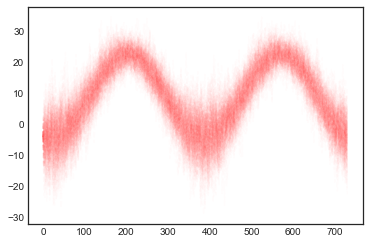

In [26]:
#M is the number of monte carlo paths to simulate
M = 10000
invariants = np.zeros((tau,M))
#Fractional Brownian Motion
H = 0.61
f = FBM(n=tau, hurst=H, length=tau, method='daviesharte')
#
for i in range(M):
    invariants[:,i] = np.diff(f.fbm())
vol_proj = (VolResults.predict(X_proj[volcols]))**0.5
sig_hat = np.expand_dims(vol_proj, axis=1)*invariants
AR = np.zeros(sig_hat.shape)
for i in range(sig_hat.shape[0]-1):
    AR[i+1] = ar_res.params[0]*AR[i]+ sig_hat[i]
x_proj = X_proj[cols]
Mean_Temp = np.expand_dims(results.predict(x_proj ),axis=1)
Temp_Paths = np.repeat(Mean_Temp,M,axis=1)+ AR
#plt.plot(Temp_Paths[:,0:100],'r--',alpha = 0.01);

In [27]:
T_innov = pd.DataFrame(invariants)
T_out = pd.DataFrame(Temp_Paths)
T_out.index = np.arange(T.index[-1],T.index[-1] + dt.timedelta(tau),dt.timedelta(days=1)).astype(dt.datetime)
T_innov.index = T_out.index
#T_out.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tout.pkl")
#T_innov.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tinnov.pkl")
#T_out.mean(axis = 1).plot()
#T_out["model#"] = 1